# De relatie tussen zeespiegelstijging en tsunami’s
In deze datastory wordt onderzocht of er een relatie bestaat tussen de stijgende zeespiegel en de impact van tsunami’s. Om deze vraag te kunnen beantwoorden, wordt de kwestie benaderd vanuit meerdere perspectieven, elk met een eigen invalshoek. 

Het eerste perspectief stelt dat tsunami’s een toenemend gevaar voor de toekomst vormen, omdat naar mate de zeespiegel stijgt de gemiddelde impact van tsunami’s toeneemt. Om dit te analyseren, wordt gebruikgemaakt van een samengestelde ‘impactscore’, gebaseerd op drie factoren: het aantal dodelijke slachtoffers, het totaal aantal getroffen personen en de economische schade (in duizenden Amerikaanse dollars). Daarnaast wordt in dit perspectief gekeken naar de gemiddelde schade, het aantal verwoeste woningen en het effect van tsunami’s op slachtoffers.
Het viel op dat er een aantal tsunami’s in de dataset zaten die significant grotere impact hadden, hiervoor is een apart perspectief opgesteld die zich focust op deze zwaardere tsunami’s in plaats van de gemiddelde lijn. Dit tweede perspectief zal zich focussen op de zwaarste tsunami’s (outliers) en hoe deze juist niet veroorzaakt worden door de stijgende zeespiegel.
Tot slot wordt in het derde perspectief de nadruk gelegd op hoe geologische factoren effect hebben op de impact van tsunami's.


## Gemiddelde impact score
Om te onderzoeken of de stijgende zeespiegel invloed heeft op de impact van plaatsgevonden tsunami’s is per jaar de gemiddelde impactscore berekend. Deze wordt vervolgens vergeleken met de zeespiegelstijging, met als nulpunt het jaar 1900. De gemiddelde impactscore per jaar wordt weergeven op een logaritmische schaal. 

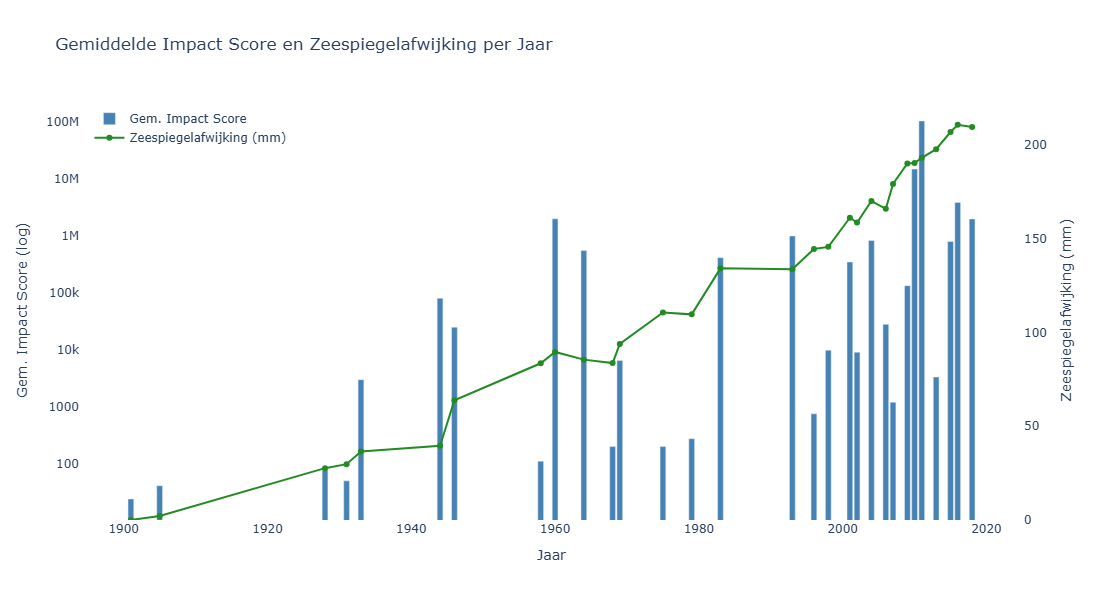

In [29]:

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
sea_level_df = pd.read_csv("Global_sea_level_rise.csv")

sea_df = pd.read_csv('Global_sea_level_rise.csv')
dist_df = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')

tsunami_df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'tsunami'].copy()
flood_df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'flood'].copy()

tsunami_df.columns = tsunami_df.columns.str.strip()
flood_df.columns = flood_df.columns.str.strip()
sea_df.rename(columns={'year': 'Year'}, inplace=True)

#subsets om samen te voegen
tsunami_subset = tsunami_df[['Year', 'Disaster Subtype', 'Country', 'Region', 'Continent', 'Origin', 'River Basin',
                             'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", 'Latitude', 'Longitude', 'Location']]

flood_subset = flood_df[['Year', 'Disaster Subtype', 'Country', 'Region', 'Continent', 'Origin', 'River Basin',
                         'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", 'Latitude', 'Longitude', 'Location']]

#eerste twee samen voegen
disaster_df = pd.concat([tsunami_subset, flood_subset], ignore_index=True)

#laatste samenvoegen
merged_df = disaster_df.merge(sea_df[['Year', 'mmfrom1993-2008average']], on='Year', how='left')

#missende waardes invullen met 0
merged_df = merged_df.fillna(0)

import numpy as np 
merged_df['Total Deaths'] = pd.to_numeric(merged_df['Total Deaths'], errors='coerce').fillna(0)
merged_df['Total Affected'] = pd.to_numeric(merged_df['Total Affected'], errors='coerce').fillna(0)
merged_df["Total Damages ('000 US$)"] = pd.to_numeric(merged_df["Total Damages ('000 US$)"], errors='coerce').fillna(0)

merged_df['Impact_Score'] = merged_df[['Total Deaths', 'Total Affected', "Total Damages ('000 US$)"]].max(axis=1)

merged_df = merged_df[(merged_df['Latitude'] != 0) & (merged_df['Longitude'] != 0)]

filtered_df = merged_df[merged_df['Impact_Score'] > 0].copy()

filtered_df['Impact_Score_Log'] = filtered_df['Impact_Score'].apply(lambda x: np.log10(x + 1))

filtered_df['Year'] = pd.to_numeric(filtered_df['Year'], errors='coerce')
filtered_df = filtered_df.dropna(subset=['Year'])
filtered_df = filtered_df.sort_values('Year')
filtered_df['Year'] = filtered_df['Year'].astype(int)


avg_impact_per_year = filtered_df.groupby('Year')['Impact_Score'].mean().reset_index()

fig = go.Figure()


fig.add_trace(go.Bar(
    x=avg_impact_per_year['Year'],
    y=avg_impact_per_year['Impact_Score'],
    name='Gem. Impact Score',
    marker_color='steelblue',
    yaxis='y1',
    hovertemplate='Jaar: %{x}<br>Gem. Impact Score: %{y}<extra></extra>'
))
# Maak zeespiegelwaarden relatief t.o.v. het eerste jaar
first_year = filtered_df['Year'].min()
baseline = filtered_df.loc[filtered_df['Year'] == first_year, 'mmfrom1993-2008average'].values[0]
filtered_df['mmfrom1993-2008average'] = filtered_df['mmfrom1993-2008average'] - baseline

sea_level_data = filtered_df[['Year', 'mmfrom1993-2008average']].drop_duplicates()

fig.add_trace(go.Scatter(
    x=sea_level_data['Year'],
    y=sea_level_data['mmfrom1993-2008average'],
    name='Zeespiegelafwijking (mm)',
    mode='lines+markers',
    line=dict(color='forestgreen', width=2),
    yaxis='y2',
    hovertemplate='Jaar: %{x}<br>Zeespiegelafwijking: %{y} mm<extra></extra>'
))

fig.update_layout(
    title="Gemiddelde Impact Score en Zeespiegelafwijking per Jaar",
    xaxis=dict(title='Jaar'),
    yaxis=dict(
        title='Gem. Impact Score',
        showgrid=False,
        side='left',
        rangemode='tozero'
    ),
    yaxis2=dict(
        title='Zeespiegelafwijking (mm)',
        overlaying='y',
        side='right',
        showgrid=False,
        rangemode='tozero'
    ),
    legend=dict(x=0.01, y=0.99),
    height=600,
    plot_bgcolor='white'
)

fig.update_layout(
    yaxis=dict(
        title='Gem. Impact Score (log)',
        type='log', 
        showgrid=False,
        side='left',
        rangemode='tozero'
    ),
)

fig.show()


Aan de hand van de grafiek is te zien dat zowel de zeespiegelafwijking als de gemiddelde impact score van tsunami’s is toegenomen door de jaren heen. De zeespiegel lijkt een vrij geleidelijke toename te zijn, in tegenstelling tot de impact score die een onregelmatige verdeling vertoont met grote variaties tussen de jaren. Desondanks lijkt de gemiddelde impact score in hoofdlijnen ook te stijgen. 

Hoewel er geen causale relatie aangetoond wordt, kan er mogelijk wel een relatie zijn tussen impact en zeespiegelafwijking. Zo valt op dat er vanaf het jaar 2000 meer jaren zijn met gemiddeld hoge impactscores, terwijl in die periode ook de zeespiegel hoog is (t.o.v. 1900).  Dit zou kunnen wijzen op een versterkend effect van de zeespiegel op de impact van tsunami’s. Het is echter niet met zekerheid te zeggen of de stijgende zeespiegel daadwerkelijk de oorzaak is, aangezien ook andere factoren een rol kunnen spelen bij de impact van tsunami’s.

## Schade aan verwoestingen na een Tsunami
De stijgende zeespiegel wordt vaak genoemd als een van de meest directe gevolgen van klimaatverandering. In kustgebieden leidt deze ontwikkeling niet alleen tot een verhoogd risico op overstromingen, maar ook tot zwaardere gevolgen bij natuurrampen zoals tsunami’s. Een van de zichtbare effecten hiervan is de toename van de schade die tsunami’s aanrichten, een ontwikkeling die samen lijkt te hangen met de mondiale zeespiegelstijging. Dat verband wordt zichtbaar in de ruimtelijke spreiding van tsunami-gerelateerde schade in de visualisatie hieronder. 

In [2]:
import pandas as pd
import plotly.graph_objects as go
import re

# Data inladen
tsunami_df = pd.read_csv("tsunami_dataset.csv")
sea_level_df = pd.read_csv("Global_sea_level_rise.csv")

# Schoonmaken tsunami data
tsunami_df = tsunami_df[['YEAR', 'DAMAGE_TOTAL_DESCRIPTION', 'COUNTRY', 'LONGITUDE', 'LATITUDE','DEATHS_TOTAL_DESCRIPTION', 'HOUSES_TOTAL_DESCRIPTION']].dropna()
tsunami_df['YEAR'] = tsunami_df['YEAR'].astype(int)

# Schoonmaken zeespiegel data
sea_level_df = sea_level_df.rename(columns={'year': 'Year', 'mmfrom1993-2008average': 'Sea_Level_Change_mm'})
sea_level_df['Year'] = sea_level_df['Year'].astype(int)
sea_level_df = sea_level_df.sort_values('Year')

# Baseline 1900 bepalen
if 1900 in sea_level_df['Year'].values:
    baseline = sea_level_df.loc[sea_level_df['Year'] == 1900, 'Sea_Level_Change_mm'].values[0]
else:
    closest_year = sea_level_df.iloc[(sea_level_df['Year'] - 1900).abs().argsort()[:1]]['Year'].values[0]
    baseline = sea_level_df.loc[sea_level_df['Year'] == closest_year, 'Sea_Level_Change_mm'].values[0]

sea_level_df['Sea_Level_Change_mm'] = sea_level_df['Sea_Level_Change_mm'] - baseline

# Zeespiegel smoothen met rolling average over 5 jaar
sea_level_df['Sea_Level_Change_mm'] = sea_level_df['Sea_Level_Change_mm'].rolling(window=5, center=True, min_periods=1).mean()

# Merge datasets en filter vanaf 1900
merged = pd.merge(tsunami_df, sea_level_df, left_on='YEAR', right_on='Year', how='inner')
merged = merged[merged['YEAR'] >= 1900].copy()

# Schadebedrag parseren
def parse_damage_amount(description):
    if not isinstance(description, str):
        return 0
    description = description.lower().replace(",", "")
    match = re.search(r'([\d\.]+)\s*(billion|million|thousand)?', description)
    if match:
        amount = float(match.group(1))
        unit = match.group(2)
        if unit == 'billion':
            return amount * 1_000
        elif unit == 'million':
            return amount
        elif unit == 'thousand':
            return amount / 1_000
        else:
            return amount
    return 0

merged['Estimated_Damage_MillionUSD'] = merged['DAMAGE_TOTAL_DESCRIPTION'].apply(parse_damage_amount).round(1)
merged['Sea_Level_Change_mm'] = merged['Sea_Level_Change_mm'].round(2)

min_sea = 0
max_sea = merged['Sea_Level_Change_mm'].max()
min_damage = merged['Estimated_Damage_MillionUSD'].min()
max_damage = merged['Estimated_Damage_MillionUSD'].max()

years = sorted(merged['YEAR'].unique())
jaar_0 = years[0]
df_year_0 = merged[merged['YEAR'] == jaar_0]

# Schade-intervals instellen in stappen van 10 miljoen (of groter als nodig)
step_size = max(10, int((max_damage - min_damage) / 10))
schade_ticks = list(range(0, int(max_damage) + step_size, step_size))

fig = go.Figure()

# Wereldkaart tsunami schade (Scattergeo) met coloraxis
fig.add_trace(go.Scattergeo(
    lon=df_year_0['LONGITUDE'],
    lat=df_year_0['LATITUDE'],
    text=df_year_0['COUNTRY'] + "<br>Schade: " + df_year_0['Estimated_Damage_MillionUSD'].astype(str) + " M$",
    marker=dict(
        color=df_year_0['Estimated_Damage_MillionUSD'],
        colorscale='OrRd',
        cmin=min_damage,
        cmax=max_damage,
        size=15,  # bollen groter gemaakt
        colorbar=None
    ),
    name='Tsunami schade',
    hoverinfo='text'
))

# Schadekleurbalk wordt via coloraxis toegevoegd in layout

# Zeespiegelbalk (lijn + bolletje)
fig.add_trace(go.Scatter(
    x=[min_sea, max_sea],
    y=[0, 0],
    mode='lines',
    line=dict(color='lightblue', width=20),
    showlegend=False,
    xaxis='x2',
    yaxis='y2'
))
fig.add_trace(go.Scatter(
    x=[merged[merged['YEAR'] == jaar_0]['Sea_Level_Change_mm'].mean()],
    y=[0],
    mode='markers',
    marker=dict(size=30, color='blue'),  # bollen groter gemaakt
    showlegend=False,
    xaxis='x2',
    yaxis='y2'
))

# Frames voor animatie
frames = []
for year in years:
    df_year = merged[merged['YEAR'] == year]
    sea_val = df_year['Sea_Level_Change_mm'].mean()
    frames.append(go.Frame(
        data=[
            go.Scattergeo(
                lon=df_year['LONGITUDE'],
                lat=df_year['LATITUDE'],
                marker=dict(color=df_year['Estimated_Damage_MillionUSD'], size=15),  # bollen groter
                text=df_year['COUNTRY'] + "<br>Schade: " + df_year['Estimated_Damage_MillionUSD'].astype(str) + " M$",
            ),
            go.Scatter(
                x=[min_sea, max_sea],
                y=[0, 0],
                mode='lines',
                line=dict(color='lightblue', width=20),
                xaxis='x2',
                yaxis='y2',
                showlegend=False
            ),
            go.Scatter(
                x=[sea_val],
                y=[0],
                mode='markers',
                marker=dict(size=30, color='blue'),  # bollen groter
                xaxis='x2',
                yaxis='y2',
                showlegend=False
            )
        ],
        name=str(year)
    ))

fig.frames = frames

# Coloraxis toewijzen aan scattergeo marker en frames
fig['data'][0]['marker']['coloraxis'] = 'coloraxis'
for frame in fig.frames:
    frame.data[0]['marker']['coloraxis'] = 'coloraxis'

# Layout update met kaart, coloraxis en assen voor zeespiegel en schade, netjes onder elkaar
fig.update_layout(
    title_text='Tsunami Schade en Zeespiegelstijging per Jaar',
    geo=dict(
        scope='world',
        projection_type='equirectangular',
        showland=True,
        landcolor="rgb(240, 240, 240)",
        oceancolor="rgb(173, 216, 230)",
        showocean=True,
        showcountries=True,
        countrycolor="gray",
        lonaxis_range=[-180, 180],
        lataxis_range=[-90, 90],
        domain=dict(x=[0, 1], y=[0.45, 1])
    ), 
    height=700,
    margin=dict(t=50, b=40),

    coloraxis=dict(
        colorscale='blugrn',
        cmin=min_damage,
        cmax=max_damage,
        colorbar=dict(
            title=dict(
                text='Schade (miljoen USD)',
                font=dict(size=14)
            ),
            orientation='h',
            yanchor='bottom',
            y=0.38,
            xanchor='center',
            x=0.35,
            len=0.8,
            tickmode='array',
            tickvals=schade_ticks,
            tickfont=dict(size=12)
        )
    ),

    xaxis2=dict(
        domain=[0.15, 0.85],
        anchor='y2',
        range=[min_sea, max_sea],
        title=dict(
            text='Zeespiegelstijging (mm)',
            font=dict(size=14)
        ),
        showgrid=False,
        zeroline=False,
        showticklabels=True,
        tickfont=dict(size=12),
        overlaying='free',
        position=0.5,
        side='bottom'
    ),
    yaxis2=dict(
        domain=[0.33, 0.35],
        anchor='x2',
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),

    updatemenus=[dict(
        type='buttons',
        direction='right',
        showactive=True,
        x=0.1,
        y=0.28,
        xanchor='center',
        yanchor='bottom',
        pad={"r": 10, "t": 10},
        buttons=[
            dict(
                method='animate',
                args=[None, {'frame': {'duration': 600, 'redraw': True}, 'fromcurrent': True}],
                label='▶︎'
            ),
            dict(
                method='animate',
                args=[[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}],
                label='||'
            )
        ]
    )],

    sliders=[{
        "currentvalue": {"prefix": "Jaar: ", "visible": True, "xanchor": "right"},
        "steps": [{
            "args": [[str(year)], {"frame": {"duration": 800, "redraw": True}, "mode": "immediate"}],
            "label": str(year),
            "method": "animate"
        } for year in years],
        "x": 0,
        "y": 0.35,
        "len": 1.0,
        "xanchor": "left",
        "yanchor": "top",
        "pad": {"b": 5, "t": 30},
    }]
)

fig.show()


Op de wereldkaart is te zien dat de zwaarst getroffen gebieden zich vooral bevinden in kustregio’s zoals Zuidoost-Azië. Deze gebieden zijn vaak laaggelegen, dichtbevolkt en economisch kwetsbaar. Juist in zulke regio’s kan een relatief kleine verandering in zeeniveau grote gevolgen hebben (Kornei & Kornei, 2022). De kaart laat zien dat waar dit risico het grootst is, de schade ook het meest geconcentreerd voorkomt. Naarmate de zeespiegel stijgt, en de jaren toenemen, wordt de schade van tsunami's (in USD) steeds hoger.
Ook in Plot 3 wordt duidelijk hoe de financiële schade van tsunami’s door de jaren heen is toegenomen. In deze visualisatie zijn de jaarlijkse schadebedragen in USD weergegeven, waarbij opvalt dat vooral in de meer recente jaren de economische impact aanzienlijk hoger ligt. De extreem hoge schadebedragen van de tsunami’s in 2004 en 2011 zijn uit de grafiek verwijderd, omdat deze uitschieters de schaal zo beïnvloedden dat de overige gegevens minder goed zichtbaar werden.

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import re

# ------- 1. Parser voor schadebedragen -------
def parse_damage(val):
    if pd.isna(val):
        return np.nan
    val = val.upper().strip()

    if 'BILLION' in val or 'B' in val:
        nums = re.findall(r'\d+\.?\d*', val)
        if nums:
            return float(nums[0]) * 1000
    elif 'MILLION' in val or 'M' in val:
        nums = re.findall(r'\d+\.?\d*', val)
        if nums:
            return float(nums[0])
    elif 'LIMITED' in val or 'LIITED' in val or '<$1' in val:
        return 0.5
    else:
        nums = re.findall(r'\d+\.?\d*', val)
        if nums:
            return float(nums[0])

    return np.nan

# ------- 2. Kolommen hernoemen & schade omzetten -------
merged = merged.rename(columns={
    'year': 'YEAR',
    'mmfrom1993-2008average': 'Sea_Level_Change_mm'
})

merged['Estimated_Damage_MillionUSD'] = merged['DAMAGE_TOTAL_DESCRIPTION'].apply(parse_damage)

# ------- 3. Gemiddelden per jaar berekenen -------
bubble_data = merged.groupby('YEAR').agg({
    'Sea_Level_Change_mm': 'mean',
    'Estimated_Damage_MillionUSD': 'mean',
    'DAMAGE_TOTAL_DESCRIPTION': 'count'
}).reset_index().rename(columns={'DAMAGE_TOTAL_DESCRIPTION': 'Tsunami_Count'})

# Filter voor geldige waarden en max schade 15 miljoen
bubble_data = bubble_data.dropna(subset=['Sea_Level_Change_mm', 'Estimated_Damage_MillionUSD'])
bubble_data = bubble_data[bubble_data['Estimated_Damage_MillionUSD'] <= 100]

# ------- 4. Plot met bar (schade) + lijn (zeespiegel) -------
fig = go.Figure()

# Bar voor schade met aangepaste hover info én verplaatste colorbar
fig.add_trace(go.Bar(
    x=bubble_data['YEAR'],
    y=bubble_data['Estimated_Damage_MillionUSD'],
    name='',
    showlegend=False,
    marker=dict(
        color=bubble_data['Estimated_Damage_MillionUSD'],
        colorscale='blugrn',
        colorbar=dict(
            title='Schade (mln USD)',
            x=1.125,            # Iets naar rechts verplaatst
            y=0.425,             # Iets naar beneden (midden van de grafiek)
            xanchor='left',
            yanchor='middle',
            len=0.9           # Korte schaalbalk
        ),
        showscale=True
    ),
    hovertemplate=
        '<b>Jaar:</b> %{x}<br>'+
        '<b>Gem. schade:</b> %{y:.2f} mln USD<br>'+
        '<b>Aantal tsunami’s:</b> %{customdata}<br>'+
        '<b>Gem. zeespiegelstijging:</b> %{text:.2f} mm<br>',
    customdata=bubble_data['Tsunami_Count'],
    text=bubble_data['Sea_Level_Change_mm'],
))


# Lijn voor zeespiegel zonder markers, met eigen y-as
fig.add_trace(go.Scatter(
    x=bubble_data['YEAR'],
    y=bubble_data['Sea_Level_Change_mm'],
    name='Gem. zeespiegelstijging (mm)',
    yaxis='y2',
    mode='lines',  # alleen lijn, geen markers
    line=dict(color='steelblue', width=3),
    hoverinfo='none'  # hover info via bar, dus hier niet nodig
))

# Layout met twee y-assen
fig.update_layout(
    title='Gemiddelde Tsunami Schade en Zeespiegelstijging per Jaar',
    xaxis=dict(title='Jaar'),
    yaxis=dict(
        title='Gem. schade (mln USD)',
        rangemode='tozero'
    ),
yaxis2=dict(
    title='Gem. zeespiegelstijging (mm)',
    overlaying='y',
    side='right',
    rangemode='tozero',
    title_font=dict(
        size=14,
    ),
    title_standoff=30
),

    height=600,
    width=775,
    margin=dict(l=50, r=70, t=80, b=50)
)

fig.show()

De stijgende schadebedragen suggereren dat tsunami’s in staat zijn om steeds meer waardevolle infrastructuur en bebouwing te treffen. Een hoger zeeniveau kan ertoe leiden dat het water verder landinwaarts reikt en daardoor grotere gebieden beschadigt. Tegelijkertijd zorgt de groei van steden in kustregio’s ervoor dat de potentiële schade per gebeurtenis stijgt. Hoewel er meerdere factoren meespelen, sluit dit patroon aan bij het argument, een stijgende zeespiegel draagt bij aan het verergeren van de impact van tsunami’s. Plot 3 onderstreept daarmee de economische consequenties van klimaatverandering in kustgebieden. Ook in Plot 2 wordt zichtbaar hoe de verwoestende impact van tsunami’s is toegenomen onder invloed van een stijgende zeespiegel. De grafiek toont het aantal dodelijke slachtoffers en het aantal volledig verwoeste huizen per tsunami.

In [4]:
import pandas as pd
import plotly.graph_objs as go

# --- 1. Mapping naar numerieke doden ---
deaths_mapping = {
    "None reported": 0,
    "Few (~1 to 50 people)": 25,
    "Some (~51 to 100 people)": 75,
    "Many (~101 to 1,000 people)": 550,
    "Very Many (~1001 or more people)": 1500
}
houses_map = {
    'Few (~1 to 50 houses)': 25,
    'Some (~51 to 100 houses)': 75,
    'Many (~101 to 1000 houses)': 550,
    'Very Many (~1001 or more houses)': 1500
}
merged["HOUSES_ESTIMATED"] = merged["HOUSES_TOTAL_DESCRIPTION"].map(houses_map)
merged["DEATHS_ESTIMATED"] = merged["DEATHS_TOTAL_DESCRIPTION"].map(deaths_mapping)

# --- 2. Zeespiegel corrigeren ---
min_sea = merged["Sea_Level_Change_mm"].min()
merged["Sea_Level_Corrected"] = merged["Sea_Level_Change_mm"] - min_sea

# --- 3. Bepaal decennium (optioneel) ---
merged["Decennium"] = (merged["Year"] // 10) * 10

# --- 4. Groeperen per 20mm zeespiegelbin ---
merged["Sea_Level_Bin"] = (merged["Sea_Level_Corrected"] // 20) * 20
grouped = merged.groupby("Sea_Level_Bin").agg({
    "DEATHS_ESTIMATED": "mean",
    "HOUSES_ESTIMATED": "mean",
    "Year": lambda x: int(x.mean())  # gemiddeld jaar als representatie
}).reset_index()

# --- 5. Laatste bin verwijderen ---
max_bin = grouped["Sea_Level_Bin"].max()
grouped = grouped[grouped["Sea_Level_Bin"] < max_bin]

# --- 6. Plot maken ---
fig = go.Figure()
min_sea = merged["Sea_Level_Change_mm"].min()
merged["Sea_Level_Corrected"] = merged["Sea_Level_Change_mm"] - min_sea


merged["Sea_Level_Bin"] = (merged["Sea_Level_Corrected"] // 20) * 20
grouped = merged.groupby("Sea_Level_Bin").agg({
    "DEATHS_ESTIMATED": "mean",
    "HOUSES_ESTIMATED": "mean",
    "Year": lambda x: int(x.mean())  # gemiddeld jaar als representatie
}).reset_index()

# --- 5. Laatste bin verwijderen ---
max_bin = grouped["Sea_Level_Bin"].max()
grouped = grouped[grouped["Sea_Level_Bin"] < max_bin]


# Lijn: Aantal doden (blauwgroen tint)
fig.add_trace(go.Scatter(
    x=grouped["Sea_Level_Bin"],
    y=grouped["DEATHS_ESTIMATED"],
    name="Gemiddeld aantal doden",
    mode="lines",
    line=dict(color="#1f77b4"),  # steel blue / blauw tint
    hovertemplate=(
        "%{y:.0f}<br>"
    ),
    customdata=grouped[["Year"]].values
))

# Lijn: Aantal verwoeste huizen (groentint)
fig.add_trace(go.Scatter(
    x=grouped["Sea_Level_Bin"],
    y=grouped["HOUSES_ESTIMATED"],
    name="Gemiddeld aantal verwoeste huizen",
    mode="lines",
    line=dict(color="#2ca02c"),  # forest green / groen tint
    yaxis="y2",
    hovertemplate=(
        "%{y:.0f}<br>" +
        "Zeespiegelstijging: %{x:.0f} mm<br>" +
        "Gemiddeld jaar: %{customdata[0]:.0f}"
    ),
    customdata=grouped[["Year"]].values
))

# --- 7. Layout ---
fig.update_layout(
    title="Effect van zeespiegelstijging op slachtoffers en verwoeste huizen",
    xaxis=dict(title="Zeespiegelstijging (mm vanaf 0, per 20 mm gegroepeerd)"),
    yaxis=dict(
        title="Gemiddeld aantal doden",
        tickfont=dict(color="#1f77b4")  # zelfde blauw als lijn
    ),
    yaxis2=dict(
        title="Gemiddeld aantal verwoeste huizen",
        tickfont=dict(color="#2ca02c"),  # zelfde groen als lijn
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.00, y=1.),
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


Opvalled is dat beide lijnen over het algemeen stijgen naarmate de zeespiegel toeneemt. Hoewel er schommelingen zichtbaar zijn, laten vooral de pieken bij 120 mm en 180 mm zeespiegelstijging een sterke toenama van verwoeste huizen zien. Het aantal slachtoffers vertoont een soortgelijk patroon, met een duidelijke piek bij 180 mm.
Deze gegevens suggereren dat een hogere zeespiegel niet alleen leidt tot meer schade, zoals te zien in plot 2 en 3, maar ook samenhangt met een hoger aantal slachtoffers.

## De zwaarste tsunami's in beeld
In de afgelopen decennia hebben zich wereldwijd enkele uitzonderlijk zware tsunami’s voorgedaan. Een bekend voorbeeld is de tsunami die Japan in 2011 trof. Deze ramp leidde tot ruim 19.000 doden en enorme economische schade, inclusief de kernramp in Fukushima. Zulke extreme gebeurtenissen vormen duidelijke uitschieters binnen de dataset. In de volgende grafieken wordt onderzocht hoe de doden en economische schade veroorzaakt door deze zwaarste tsunami’s, zich verhouden tot de zeespiegelafwijking.

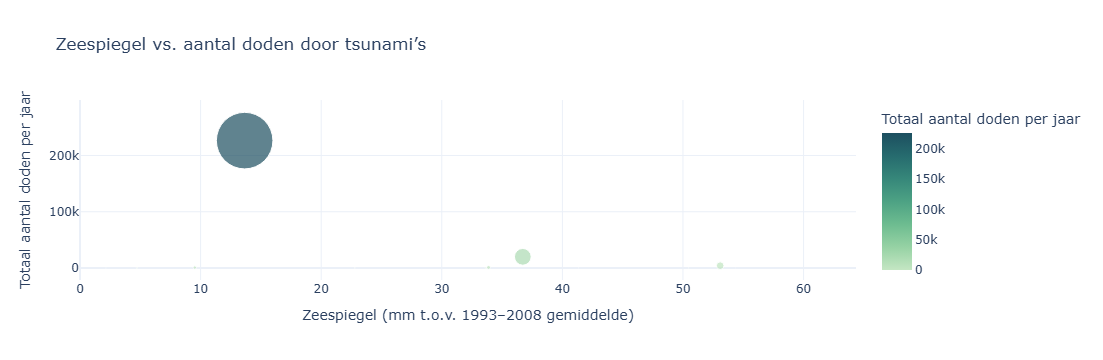

In [14]:
disasters = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')
sea_level = pd.read_csv('Global_sea_level_rise.csv')

tsunamis = disasters[disasters['Disaster Subtype'].isin(['Tsunami', 'Tsunami/Tidal wave'])]

tsunami_deaths = tsunamis.groupby('Year')['Total Deaths'].sum().reset_index()

combined = pd.merge(tsunami_deaths, sea_level, left_on='Year', right_on='year', how='inner')

fig = px.scatter(
    combined,
    x='mmfrom1993-2008average',
    y='Total Deaths',
    color='Total Deaths',
    size='Total Deaths',
    hover_name='Year',
    title='Zeespiegel vs. aantal doden door tsunami’s',
    labels={
        'mmfrom1993-2008average': 'Zeespiegel (mm t.o.v. 1993–2008 gemiddelde)',
        'Total Deaths': 'Totaal aantal doden per jaar'
    },
    size_max=40,
    color_continuous_scale='blugrn' 
)

max_sea_level = combined['mmfrom1993-2008average'].max()
fig.update_xaxes(range=[0, max_sea_level + 10])  
fig.update_layout(template='plotly_white')
fig.show()



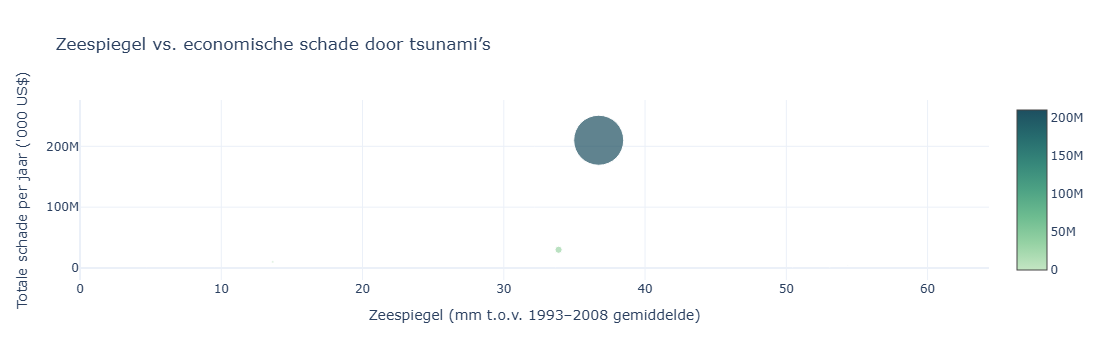

In [17]:
import pandas as pd
import plotly.graph_objects as go

disasters = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')
sea_level = pd.read_csv('Global_sea_level_rise.csv')

tsunamis = disasters[disasters['Disaster Subtype'].isin(['Tsunami', 'Tsunami/Tidal wave'])]

damages_per_year = tsunamis.groupby('Year')["Total Damages ('000 US$)"].sum().reset_index()

combined = pd.merge(damages_per_year, sea_level, left_on='Year', right_on='year', how='inner')

max_damage = combined["Total Damages ('000 US$)"].max()
marker_sizes = combined["Total Damages ('000 US$)"] / max_damage * 50

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=combined['mmfrom1993-2008average'],
        y=combined["Total Damages ('000 US$)"],
        mode='markers',
        name='Totale Schade',
        marker=dict(
            size=marker_sizes,
            color=combined["Total Damages ('000 US$)"],
            colorscale='blugrn',
            showscale=True,
        ),
        hovertext=combined['Year'],
        hoverinfo='text+x+y'
    )
)

max_sea_level = combined['mmfrom1993-2008average'].max()
fig.update_xaxes(
    title='Zeespiegel (mm t.o.v. 1993–2008 gemiddelde)',
    range=[0, max_sea_level + 10]
)

fig.update_yaxes(title="Totale schade per jaar ('000 US$)")

fig.update_layout(
    title='Zeespiegel vs. economische schade door tsunami’s',
    template='plotly_white'
)

fig.show()



Bovenstaande plots tonen aan dat de zeespiegel geen waarschijnlijke factor is voor het veroorzaken van de zwaarste tsunami's.
Er zijn twee observaties die dit ondersteunen. 

In het plot waarin de zeespiegel en het aantal doden worden vergeleken is te zien dat in 2004 uitzonderlijk veel slachtoffers zijn gevallen. Vervolgens is te zien dat in de jaren 2011 en 2018, ondanks een hogere zeespiegel, er minder getroffen slachtoffers zijn. Dit suggereert dat de ernst en impact van de grootste tsunami's vooral worden bepaald door andere factoren en niet zozeer door de hoogte van de zeespiegel op het moment van de ramp.
In het plot waarin de zeespiegel en de economische schade worden vergeleken, is te zien dat het grootste schadebedrag in 2011 plaatsvond. Verder is er geen duidelijke toename van schadebedragen bij andere zware tsunami’s naarmate de zeespiegel stijgt. De gegevens suggereren daarom dat ook de economische schade bij de zwaarste tsunami’s niet consistent samenhangt met een stijgende zeespiegel.


## Wereldwijde verspreiding van tsunami’s en hun impact
De geografische ligging speelt een belangrijke rol bij het ontstaan en de ernst van tsunami's. Om beter beeld te krijgen van waar deze natuurrampen zich voordoen en hoe zwaar ze zijn geweest, is een wereldkaart opgesteld. Deze visualisatie brengt de ruimtelijke spreiding van tsunami's in kaart en combineert meerdere factoren, zoals het aantal slachtoffers, getroffen mensen en economische schade, om de impact per locatie weer te geven. 

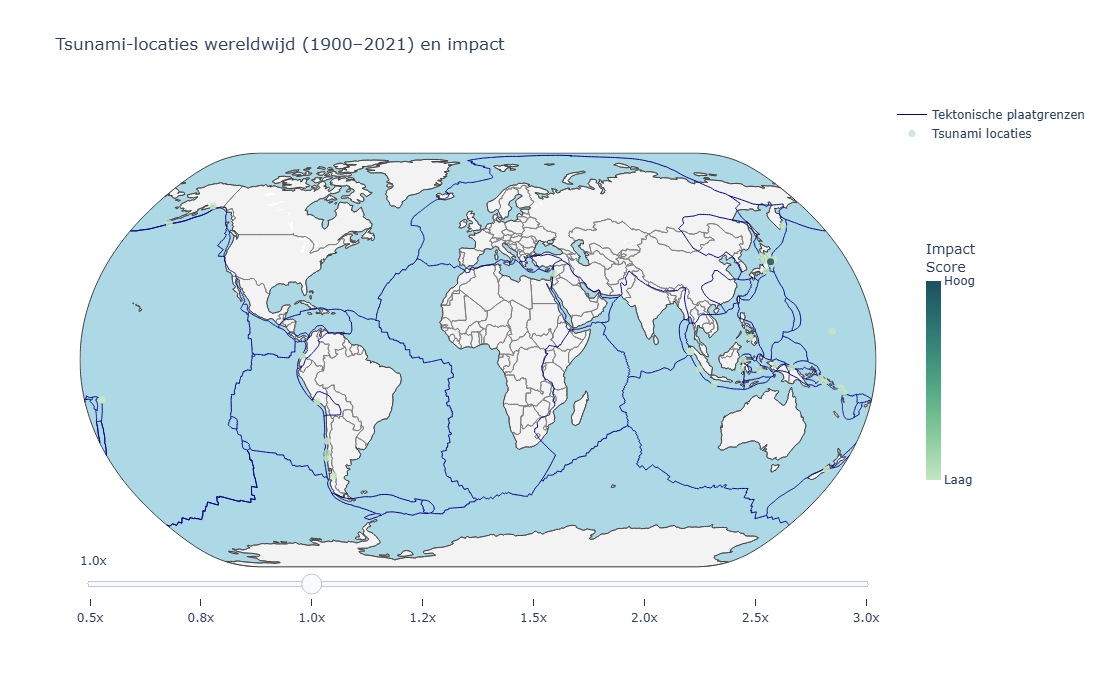

In [27]:
import json
import pandas as pd
import plotly.graph_objects as go
dist_df = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')
sea_lvl_df = pd.read_csv('Global_sea_level_rise.csv')
df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'tsunami'].copy()
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df["Total Damages ('000 US$)"] = pd.to_numeric(df["Total Damages ('000 US$)"], errors='coerce').fillna(0)
df["Total Affected"] = pd.to_numeric(df["Total Affected"], errors='coerce').fillna(0)
df['Impact_Score'] = df[['Total Deaths', 'Total Affected', "Total Damages ('000 US$)"]].max(axis=1)
df = df.dropna(subset=['Latitude', 'Longitude'])

with open('PB2002_boundaries.json') as f:
    plates_geojson = json.load(f)
def make_geo(scale=1.0):
    return dict(
        projection_type='natural earth',
        projection_scale=scale,
        showland=True,
        landcolor='rgb(243, 243, 243)',
        showcountries=True,
        countrycolor='gray',
        showocean=True,
        oceancolor='lightblue',
    )
fig = go.Figure()
legend_added = False
for feature in plates_geojson['features']:
    geometry = feature['geometry']
    coords = geometry['coordinates']

    if geometry['type'] == 'LineString':
        lons, lats = zip(*coords)
        fig.add_trace(go.Scattergeo(
            lon=lons,
            lat=lats,
            mode='lines',
            line=dict(width=1, color='darkblue'),
            name='Tektonische plaatgrenzen' if not legend_added else None,
            showlegend=not legend_added
        ))
        legend_added = True

    elif geometry['type'] == 'MultiLineString':
        for line in coords:
            lons, lats = zip(*line)
            fig.add_trace(go.Scattergeo(
                lon=lons,
                lat=lats,
                mode='lines',
                line=dict(width=1, color='blue'),
                name='Tektonische plaatgrenzen' if not legend_added else None,
                showlegend=not legend_added
            )),
            legend_added = True
sea_lvl_df['Sea_Level_Change_mm'] = sea_lvl_df['mmfrom1993-2008average'].clip(lower=0)
df = df.merge(sea_lvl_df[['year', 'Sea_Level_Change_mm']], left_on='Year', right_on='year', how='left')

fig.add_trace(go.Scattergeo(
    lon=df['Longitude'],
    lat=df['Latitude'],
    mode='markers',
    hovertemplate = (
        "<b>%{customdata[0]}</b><br>" +
        "Jaar: %{customdata[1]}<br>" +
        "Doden: %{customdata[2]:,}<br>" +
        "Getroffen: %{customdata[3]:,}<br>" +
        "Schade: $%{customdata[4]:,}k<br>" +
        "Impact Score: %{customdata[5]:,.0f}<br>" +
        "Zeespiegelstijging ten opzichte van 1900: %{customdata[6]:.1f} mm <extra></extra>"
    ),
customdata=df[['Country', 'Year', 'Total Deaths', 'Total Affected',
               "Total Damages ('000 US$)", 'Impact_Score', 'Sea_Level_Change_mm']].values,
    name='Tsunami locaties',
    marker=dict(
        size=7,
        color=df['Impact_Score'],
        colorscale='blugrn',
        cmin=df['Impact_Score'].min(),
        cmax=df['Impact_Score'].max(),
        opacity=0.85,
        colorbar=dict(
            title='Impact<br>Score',
            tickvals=[df['Impact_Score'].min(), df['Impact_Score'].max()],
            ticktext=['Laag', 'Hoog'],
            x=1.05,
            y=0.5,
            len=0.5,
            thickness=15
        )
    )
))

fig.update_layout(
    title='Tsunami-locaties wereldwijd (1900–2021) en impact',
    geo=make_geo(scale=1.0),
    height=700,
    sliders=[dict(
        active=2,
        pad={"t": 50},
        x=0.0,
        y=0.0,
        xanchor='left',
        yanchor='bottom',
        steps=[
            dict(label=f'{s:.1f}x', method='relayout', args=[{'geo.projection.scale': s}])
            for s in [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
        ]
    )]
)
fig.show()

De wereldkaart hierboven toont alle geregistreerde tsunami's tussen 1900 en 2021. Elke stip markeert een locatie waar een tsunami heeft plaatsgevonden, waarbij de kleurenintensiteit de ernst van de ramp weergeeft. Deze impactscore is gebaseed op het hoogse aantal van drie indicatoren: het aantal doden, het aantal getroffenen of de economische schade. Hoe donker de stip, hoe groter de impact van de betreffende tsunami. 

Wat direct opvalt, is de sterke geografische clustering van deze rampen. Vrijwel alle tsunami's vonden plaats in de nabijheid van tektonische plaatgrenzen, die op de kaart als grote lijnen zichtbaar zijn. De ligging op of nabij deze grenzen blijkt dus een belangrijke factor in het ontstaan van zware rampen, wat goed te verklaren is doordat Japan precies op de grens van twe tektonische platen ligt, neem bijvoorbeeld de tsunami die in 2011 Japan trof.

## Regionale verschillen in totale tsunami-impact
De visualisatie hierboven toont waar tsunami's zich hebben voorgedaan, maar biedt nog geen totaalbeeld van de schade per regio. Om dat beter inzichtelijk te maken, laat deze grafiek de opgetelde impactscore van alle tsunami's per wereldregio zien. Zo ontstaat een overzicht van welke gebieden historisch gezien het zwaarst zijn getroffen.

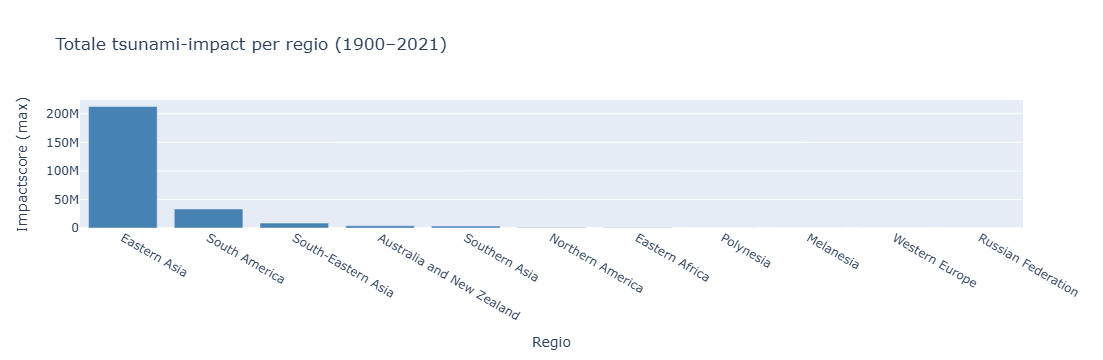

In [25]:
import pandas as pd
import plotly.express as px

dist_df = pd.read_csv('1900_2021_DISASTERS.xlsx - emdat data.csv')
df = dist_df[dist_df['Disaster Subtype'].str.lower() == 'tsunami'].copy()

df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df["Total Damages ('000 US$)"] = pd.to_numeric(df["Total Damages ('000 US$)"], errors='coerce').fillna(0)
df["Total Affected"] = pd.to_numeric(df["Total Affected"], errors='coerce').fillna(0)

df['Impact_Score'] = df[['Total Deaths', 'Total Affected', "Total Damages ('000 US$)"]].max(axis=1)

region_stats = df.groupby('Region')[['Impact_Score', 'Total Deaths', 'Total Affected']].sum().reset_index()

fig = px.bar(region_stats.sort_values(by='Impact_Score', ascending=False),
             x='Region', y='Impact_Score',
             hover_data=['Total Deaths', 'Total Affected'],
             title='Totale tsunami-impact per regio (1900–2021)',
             labels={'Impact_Score': 'Maximale impactscore'},
            color_discrete_sequence=['#4682B4'])

fig.update_layout(xaxis_title='Regio', yaxis_title='Impactscore (max)')

fig.show()

Wat direct opvalt in de grafiek, is dat Azië en Oceanië met ruime voorsprong de hoogste totaalscores laten zien. Deze regio's vormen duidelijk het zwaartepunt van wereldwijde tsunami-acitvitit, zowel qua frequentie als qua impact. Dat beeld sluit aan bij de eerdere visualisatie, waar veel zware rampen zichtbaar waren in gebieden rondom de tektonische actieve Ring Of Fire (Roque et al., 2023).

De impactscore is hier opnieuw een nuttige indicator, omdat het drie verschillende vormen van schade combineert: het aantal doden, het aantal getroffenen en de economische schade. Daarmee geeft de grafiek niet alleen inzicht in waar tsunami's plaatsvinden, maar ook in hoe zwaar ze gemiddeld uitpakken. Sommige regio's worden bijvoorbeeld vaker economisch getroffen, terwijil andere juist hogere slachtofferaantallen kennen. Door deze factoren samen te brengen, onstaat een evenwichtiger beeld van de totale impact per regio.

Tot slot onderstreept de grafiek ook waar het risico voor de toekomst het grootst blijft. Juist in regio's met hoge scores bevinden zich op plekken nabij tektonische grenzen, die kwetsbaar zijn voor aardbevingen. 

## Samenvatting
De stijgende zeespiegel is een groeiende zorg in het kader van natuurrampen, met name bij tsunami’s. Om te onderzoeken of deze stijging invloed heeft op de impact van tsunami’s, werd een analyse uitgevoerd waarbij de gemiddelde jaarlijkse impactscore werd vergeleken met de zeespiegelafwijkingen sinds 1900. Hoewel de zeespiegel geleidelijk toeneemt en de impactscores meer schommelen, vertonen beide een stijgende lijn. Verdere visualisaties laten zien dat ook de economische schade en het aantal slachtoffers in recente jaren zijn toegenomen, vooral in laaggelegen, dichtbevolkte gebieden. Toch wijst aanvullend onderzoek uit dat er geen direct verband is tussen een hogere zeespiegel en het ontstaan of de ernst van de zwaarste tsunami’s. De geografische ligging, met name een ligging naast tektonische plaatgrenzen, blijkt hierin een veel grotere rol te spelen. Regionale data toont aan dat Azië en Oceanië het zwaarst getroffen worden, wat het belang onderstreept van gerichte rampenpreventie in deze gebieden. Er kan wel een correlatie zijn tussen impact en zeespiegel, maar bij de outliers is dit niet het geval. Uit de analyse is gebleken dat de grootste tsunami’s niet direct samenhangen met een zeespiegelstijging.

## Referenties
ALL NATURAL DISASTERS 1900-2021 / EOSDIS. (2021, 10 oktober). Kaggle. https://www.kaggle.com/datasets/brsdincer/all-natural-disasters-19002021-eosdis<br> Global Sea level rise. (2024, 22 januari). Kaggle. https://www.kaggle.com/datasets/jarredpriester/global-sea-level-rise<br> Kornei, K., & Kornei, K. (2022, 31 januari). Rising Seas Boost Tsunami Impacts on Distant Shorelines. Eos. https://eos.org/articles/rising-seas-boost-tsunami-impacts-on-distant-shorelines?utm_source=chatgpt.com<br> Roque, P. J. C., Violanda, R. R., Bernido, C. C., & Soria, J. L. A. (2023, 1 april). Earthquake Occurrences in the Pacific Ring of Fire Exhibit a Collective Stochastic Memory for Magnitudes, Depths, and Relative Distances of Events. arXiv.org. https://arxiv.org/abs/2304.00279?<br>Tsunami dataset. (2020, 31 augustus). Kaggle. https://www.kaggle.com/datasets/andrewmvd/tsunami-dataset

## Externe links
Link naar Github Repository:<br>
https://github.com/roosz/informatievisualisatie
